# Kherson Dam Break *end-to-end* floodmap

* **Last Modified**: 30-11-2023
* **Authors**: Gonzalo Mateo-García, Enrique Portalés-Julià
---

This notebook shows how to produce flood extent maps from Sentinel-2 and Landsat using the clouds aware flood sementation model proposed in:

> E. Portalés-Julià, G. Mateo-García, C. Purcell, and L. Gómez-Chova [Global flood extent segmentation in optical satellite images](https://www.nature.com/articles/s41598-023-47595-7). _Scientific Reports 13, 20316_ (2023). DOI: 10.1038/s41598-023-47595-7.

In particular, the notebook shows how to: query the available S2 and Landsat images, download them, run inference with the model and vectorize the model outputs to derive prepost event floodmaps. We focus in the region of Nova Kakhovka, Kherson, Ukraine, where recently a dam break caused several flooding.

**Note**: If you run this notebook in Google Colab you may want to change the running environment to use a GPU.

## Step 1: Install and import the necessary packages

Install the `ml4floods` and `geemap` packages if not installed

```
!pip install geemap
!pip install ml4floods
```

In [80]:

!pip install geemap
!pip install ml4floods

In [81]:
import ee
ee.Authenticate()

True

In [82]:
ee.Initialize(project='ee-ml4floods')
from datetime import datetime, timezone
from georeader.readers import ee_query
from shapely.geometry import shape
import geopandas as gpd

In [83]:
from georeader.readers import S2_SAFE_reader
from georeader.save import save_cog
from georeader import window_utils, mosaic
from georeader.plot import show
from georeader.rasterio_reader import RasterioReader
import os
import torch
import numpy as np
from georeader.geotensor import GeoTensor
from ml4floods.scripts.inference import load_inference_function, vectorize_outputv1
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.data import utils
import warnings
from rasterio.plot import show
from georeader.readers import ee_image
from ml4floods.models import postprocess
from georeader import plot
import matplotlib.pyplot as plt
from ml4floods.visualization import plot_utils

## Step 2: Define query parameters: area of interest and dates

The area of interest covers the region from Nova Kakhovka to Kherson. The following code defines this AoI and queries the available S2 and Landsat images and shows them using `geemap`.

In [104]:
# aoi = shape({'type': 'Polygon',
#  'coordinates': (((33.40965055141422, 46.849975215311474),
#    (33.24671826582107, 46.923511440491325),
#    (32.936224664974134, 46.845770100334164),
#    (32.33368262768653, 46.62876156455022),
#    (32.25990197005967, 46.514641087646424),
#    (32.31216326921171, 46.408759851523826),
#    (32.843998842939385, 46.56961795883814),
#    (33.21905051921081, 46.72367854887557),
#    (33.40965055141422, 46.849975215311474)),)})


# AOI for Asheville, NC with 8 unique points
aoi = shape({
    'type': 'Polygon',
    'coordinates': [[
        (-82.5760, 35.5951),  # Downtown Asheville
        (-82.4550, 35.5750),  # Biltmore Village
        (-82.5182, 35.4740),  # West Asheville
        (-82.6075, 35.4963),  # North Asheville (Reynolds Mountain)
        (-82.6489, 35.6029),  # Eastern Asheville (Swannanoa area)
        (-82.7054, 35.6457),  # South Asheville (near Fletcher)
        (-82.5947, 35.6350),  # Asheville Airport Area
        (-82.5760, 35.5951)   # Closing the loop (repeat first point)
    ]]
})

# # AOI for Tampa Bay
# aoi = shape({
#     'type': 'Polygon',
#     'coordinates': [[
#         (-82.8422, 27.9986),  # Near Clearwater Beach
#         (-82.7362, 28.1006),  # Safety Harbor
#         (-82.5242, 28.0587),  # Tampa (Westshore area)
#         (-82.4305, 27.9127),  # Downtown Tampa
#         (-82.4501, 27.7862),  # South Tampa
#         (-82.6485, 27.6472),  # St. Pete Beach
#         (-82.7874, 27.7020),  # Madeira Beach
#         (-82.8422, 27.9986)   # Closing the loop (repeat first point)
#     ]]
# })

# # AOI for Atlanta
# aoi = shape({
#     'type': 'Polygon',
#     'coordinates': [[
#         (-84.573, 33.830),  # Near Mableton
#         (-84.360, 33.960),  # Near Sandy Springs
#         (-84.200, 33.920),  # Near Tucker
#         (-84.080, 33.780),  # Near Stonecrest
#         (-84.130, 33.650),  # Near Stockbridge
#         (-84.300, 33.550),  # Near Union City
#         (-84.500, 33.600),  # Near Fairburn
#         (-84.573, 33.830)   # Closing the loop (repeat first point)
#     ]]
# })


aoi_gpd = gpd.GeoDataFrame({'geometry':aoi},index = [0]).set_crs('epsg:4326')

## Step 3: Query available Landsat and Sentinel-2 images

In [106]:
tz = timezone.utc
start_period = datetime.strptime('2024-09-20',"%Y-%m-%d").replace(tzinfo=tz)
end_period = datetime.strptime('2024-10-05',"%Y-%m-%d").replace(tzinfo=tz)

# This function returns a GEE collection of Sentinel-2 and Landsat 8 data and a Geopandas Dataframe with data related to the tiles, overlap percentage and cloud cover
flood_images_gee, flood_collection = ee_query.query(
    area=aoi,
    date_start=start_period,
    date_end=end_period,
    producttype="both",
    return_collection=True,
    add_s2cloudless=False)

flood_images_gee.groupby(["solarday","satellite"])[["cloudcoverpercentage","overlappercentage"]].agg(["count","mean"])

cloudcoverpercentage            overlappercentage       
                                    count       mean             count   mean
solarday   satellite                                                         
2024-09-22 S2A                          1   3.081161                 1  100.0
2024-09-23 LC09                         1  47.530000                 1  100.0
2024-09-27 S2B                          1  93.095613                 1  100.0
2024-10-01 LC08                         1  87.340000                 1  100.0
2024-10-02 S2A                          1   6.518708                 1  100.0

Can use S2A 2024-09-22 and S2A 2024-10-02 as the pre and post flood images.

In [12]:
!pip install folium matplotlib mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.4 MB/s eta 0:00:00


In [107]:
import geemap.foliumap as geemap
import folium

tl = folium.TileLayer(
            tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
            attr='Google',
            name="Google Satellite",
            overlay=True,
            control=True,
            max_zoom=22,
        )

m = geemap.Map(location=aoi.centroid.coords[0][-1::-1],
               zoom_start=8)

tl.add_to(m)

flood_images_gee["localdatetime_str"] = flood_images_gee["localdatetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
showcolumns = ["geometry","overlappercentage","cloudcoverpercentage", "localdatetime_str","solarday","satellite"]
colors = ["#ff7777", "#fffa69", "#8fff84", "#52adf1", "#ff6ac2","#1b6d52", "#fce5cd","#705334"]

# Add the extent of the products
for i, ((day,satellite), images_day) in enumerate(flood_images_gee.groupby(["solarday","satellite"])):
    images_day[showcolumns].explore(
        m=m,
        name=f"{satellite}: {day} outline",
        color=colors[i % len(colors)],
        show=False)

# Add the satellite data
for (day, satellite), images_day in flood_images_gee.groupby(["solarday", "satellite"]):
    image_col_day_sat = flood_collection.filter(ee.Filter.inList("title", images_day.index.tolist()))
    bands = ["B11","B8","B4"] if satellite.startswith("S2") else ["B6","B5","B4"]
    m.addLayer(image_col_day_sat,
               {"min":0, "max":3000 if satellite.startswith("S2") else 0.3, "bands": bands},
               f"{satellite}: {day}",
               False)

aoi_gpd.explore(style_kwds={"fillOpacity": 0}, color="black", name="AoI", m=m)
folium.LayerControl(collapsed=False).add_to(m)
m

By looking at the map with the images available we select the pre and post event images from Sentinel-2

In [23]:
flood_images_gee

,geometry,cloudcoverpercentage,gee_id,proj,system:time_start,collection_name,utcdatetime,overlappercentage,solardatetime,solarday,localdatetime,satellite,localdatetime_str
title,,,,,,,,,,,,,
LC09_L1TP_016041_20240925_20240925_02_T1,"POLYGON ((-81.01084 26.40258, -80.8709 26.3734...",88.550000,LC09_016041_20240925,"{'type': 'Projection', 'crs': 'EPSG:32617', 't...",1727279737639,LANDSAT/LC09/C02/T1_TOA,2024-09-25 15:55:37.639000+00:00,3.305041,2024-09-25 10:29:17.360132+00:00,2024-09-25,2024-09-25 15:55:37.639000+00:00,LC09,2024-09-25 15:55:37
S2B_MSIL1C_20240927T160939_N0511_R140_T17RLM_20240927T194839,"POLYGON ((-82.82538 27.92516, -82.82535 27.925...",14.927175,20240927T160939_20240927T161609_T17RLM,"{'type': 'Projection', 'crs': 'EPSG:32617', 't...",1727454327676,COPERNICUS/S2_HARMONIZED,2024-09-27 16:25:27.676000+00:00,1.858607,2024-09-27 10:54:02.486369+00:00,2024-09-27,2024-09-27 16:25:27.676000+00:00,S2B,2024-09-27 16:25:27
S2B_MSIL1C_20240927T160939_N0511_R140_T17RLL_20240927T194839,"POLYGON ((-82.8004 28.01368, -82.80044 28.0137...",28.066827,20240927T160939_20240927T161609_T17RLL,"{'type': 'Projection', 'crs': 'EPSG:32617', 't...",1727454339298,COPERNICUS/S2_HARMONIZED,2024-09-27 16:25:39.298000+00:00,1.523972,2024-09-27 10:53:50.979692+00:00,2024-09-27,2024-09-27 16:25:39.298000+00:00,S2B,2024-09-27 16:25:39
S2A_MSIL1C_20240929T160051_N0511_R097_T17RLL_20240929T194757,"POLYGON ((-81.91775 28.02246, -81.91776 28.022...",10.371585,20240929T160051_20240929T160935_T17RLL,"{'type': 'Projection', 'crs': 'EPSG:32617', 't...",1727626549137,COPERNICUS/S2_HARMONIZED,2024-09-29 16:15:49.137000+00:00,86.278184,2024-09-29 10:45:56.513499+00:00,2024-09-29,2024-09-29 16:15:49.137000+00:00,S2A,2024-09-29 16:15:49
S2A_MSIL1C_20240929T160051_N0511_R097_T17RLM_20240929T194757,"POLYGON ((-81.92558 28.92519, -81.9256 28.9251...",32.935621,20240929T160051_20240929T160935_T17RLM,"{'type': 'Projection', 'crs': 'EPSG:32617', 't...",1727626534580,COPERNICUS/S2_HARMONIZED,2024-09-29 16:15:34.580000+00:00,37.974082,2024-09-29 10:45:39.008643+00:00,2024-09-29,2024-09-29 16:15:34.580000+00:00,S2A,2024-09-29 16:15:34
LC09_L1TP_017041_20241002_20241002_02_T1,"POLYGON ((-83.8707 28.47586, -83.8805 28.47768...",35.630000,LC09_017041_20241002,"{'type': 'Projection', 'crs': 'EPSG:32617', 't...",1727884915881,LANDSAT/LC09/C02/T1_TOA,2024-10-02 16:01:55.881000+00:00,100.000000,2024-10-02 10:29:19.817518+00:00,2024-10-02,2024-10-02 16:01:55.881000+00:00,LC09,2024-10-02 16:01:55
S2A_MSIL1C_20241002T161111_N0511_R140_T17RLM_20241002T195230,"POLYGON ((-83.05143 28.91274, -83.05154 28.912...",78.717811,20241002T161111_20241002T161350_T17RLM,"{'type': 'Projection', 'crs': 'EPSG:32617', 't...",1727886329287,COPERNICUS/S2_HARMONIZED,2024-10-02 16:25:29.287000+00:00,1.726178,2024-10-02 10:54:04.003664+00:00,2024-10-02,2024-10-02 16:25:29.287000+00:00,S2A,2024-10-02 16:25:29
S2A_MSIL1C_20241002T161111_N0511_R140_T17RLL_20241002T195230,"POLYGON ((-83.01969 27.22569, -83.01967 27.225...",37.081418,20241002T161111_20241002T161350_T17RLL,"{'type': 'Projection', 'crs': 'EPSG:32617', 't...",1727886340873,COPERNICUS/S2_HARMONIZED,2024-10-02 16:25:40.873000+00:00,1.419381,2024-10-02 10:53:52.427542+00:00,2024-10-02,2024-10-02 16:25:40.873000+00:00,S2A,2024-10-02 16:25:40
LC08_L1TP_016041_20241003_20241008_02_T1,"POLYGON ((-82.30079 28.47857, -82.30257 28.478...",33.220000,LC08_016041_20241003,"{'type': 'Projection', 'crs': 'EPSG:32617', 't...",1727970940877,LANDSAT/LC08/C02/T1_RT_TOA,2024-10-03 15:55:40.877000+00:00,1.771793,2024-10-03 10:29:23.438550+00:00,2024-10-03,2024-10-03 15:55:40.877000+00:00,LC08,2024-10-03 15:55:40


In [109]:
date_pre = "2024-09-22"
pre_flood = flood_images_gee[flood_images_gee.solarday == date_pre]
pre_flood

,geometry,cloudcoverpercentage,gee_id,proj,system:time_start,collection_name,utcdatetime,overlappercentage,solardatetime,solarday,localdatetime,satellite,localdatetime_str
title,,,,,,,,,,,,,
S2A_MSIL1C_20240922T161001_N0511_R140_T17SLV_20240922T195914,"POLYGON ((-82.00278 36.14079, -82.00279 36.140...",3.081161,20240922T161001_20240922T162015_T17SLV,"{'type': 'Projection', 'crs': 'EPSG:32617', 't...",1727022214589,COPERNICUS/S2_HARMONIZED,2024-09-22 16:23:34.589000+00:00,100.0,2024-09-22 10:53:09.956123+00:00,2024-09-22,2024-09-22 16:23:34.589000+00:00,S2A,2024-09-22 16:23:34


In [110]:
date_post = "2024-10-02"
post_flood = flood_images_gee[flood_images_gee.solarday == date_post]
post_flood

,geometry,cloudcoverpercentage,gee_id,proj,system:time_start,collection_name,utcdatetime,overlappercentage,solardatetime,solarday,localdatetime,satellite,localdatetime_str
title,,,,,,,,,,,,,
S2A_MSIL1C_20241002T161111_N0511_R140_T17SLV_20241002T195230,"POLYGON ((-82.00278 36.14079, -82.00279 36.140...",6.518708,20241002T161111_20241002T161350_T17SLV,"{'type': 'Projection', 'crs': 'EPSG:32617', 't...",1727886214739,COPERNICUS/S2_HARMONIZED,2024-10-02 16:23:34.739000+00:00,100.0,2024-10-02 10:53:10.106123+00:00,2024-10-02,2024-10-02 16:23:34.739000+00:00,S2A,2024-10-02 16:23:34


## Step 4: Download Sentinel-2 images

There are Sentinel-2 cloud free images on 2023-06-03 and 2023-06-05 but only the first one covers the entire AoI. For the postflood data we will use 2023-06-08, which is partially cloudy but allows to see some flood extent. We will read and mosaic the tiles T36TVS and T36TWS using **georeader**.
The advantage of this workflow over Google Earth Engine (GEE) is that the images are read directly from the Sentinel-2 public bucket into the jupyter notebook. Also, there is no size limit in the download, which may cause GEE tasks to fail sometimes.

In [120]:
%%time

dir_cache = "cache_s2"
os.makedirs(dir_cache, exist_ok=True)

def mosaic_s2(products, polygon, channels):
    products_read = products.index
    s2objs = []
    for product in products_read:
        s2_safe_folder = S2_SAFE_reader.s2_public_bucket_path(product+".SAFE", check_exists=False)
        s2obj = S2_SAFE_reader.s2loader(s2_safe_folder, out_res=10, bands=channels)
        s2obj = s2obj.cache_product_to_local_dir(dir_cache)
        s2objs.append(s2obj)

    polygon_read_dst_crs = window_utils.polygon_to_crs(polygon,
                                                       crs_polygon="EPSG:4326", dst_crs=s2objs[0].crs)

    data_memory = mosaic.spatial_mosaic(s2objs, polygon=polygon_read_dst_crs, dst_crs= s2objs[0].crs)

    return data_memory

channels = S2_SAFE_reader.BANDS_S2_L1C
tiff_pre = f"{date_pre}.tif"
if not os.path.exists(tiff_pre):
    print(f"Downloading files {tiff_pre}")
    pre_flood_memory = mosaic_s2(pre_flood, aoi,channels)
    save_cog(pre_flood_memory, tiff_pre, descriptions=S2_SAFE_reader.BANDS_S2_L1C)
else:
    print(f"Reading file {tiff_pre}")
    pre_flood = RasterioReader(tiff_pre)
    channels = pre_flood.descriptions
    pre_flood = pre_flood.load()
    pre_flood_memory = pre_flood.values

tiff_post = f"{date_post}.tif"
if not os.path.exists(tiff_post):
    print(f"Downloading file {tiff_post}")
    post_flood_memory = mosaic_s2(post_flood, aoi,channels)
    save_cog(post_flood_memory, tiff_post, descriptions=S2_SAFE_reader.BANDS_S2_L1C)
else:
    print(f"Reading file {tiff_post}")
    post_flood = RasterioReader(tiff_post)
    channels = post_flood.descriptions
    post_flood = post_flood.load()
    post_flood_memory = post_flood.values


Reading file 2024-09-22.tif
Reading file 2024-10-02.tif
CPU times: user 2.78 s, sys: 519 ms, total: 3.3 s
Wall time: 3.34 s


## Step 5: Load the model

For this we will use an Ml4floods multioutput binary model trained on the WorldFloods data set. See the [paper](https://www.nature.com/articles/s41598-023-47595-7).

In [112]:
from huggingface_hub import hf_hub_download
# os.makedirs("models/WF2_unetv2_bgriswirs", exist_ok=True)
experiment_name = "WF2_unetv2_bgriswirs"
subfolder_local = f"models/{experiment_name}"
config_file = hf_hub_download(repo_id="isp-uv-es/ml4floods",subfolder=subfolder_local, filename="config.json",
                              local_dir=".", local_dir_use_symlinks=False)
model_file = hf_hub_download(repo_id="isp-uv-es/ml4floods",subfolder=subfolder_local, filename="model.pt",
                              local_dir=".", local_dir_use_symlinks=False)

In [113]:
%%time

inference_function, config = load_inference_function(subfolder_local, device_name = 'cpu', max_tile_size=1024,
                                                     th_water=0.6, th_brightness=3500,
                                                     distinguish_flood_traces=True)

channel_configuration = config['data_params']['channel_configuration']
channels  = get_channel_configuration_bands(channel_configuration, collection_name='S2')

Loaded model weights: models/WF2_unetv2_bgriswirs/model.pt
Getting model inference function
CPU times: user 117 ms, sys: 31 ms, total: 148 ms
Wall time: 157 ms


In [114]:
def predict(input_tensor, channels = [1, 2, 3, 7, 11, 12] ):
    input_tensor = input_tensor.astype(np.float32)
    input_tensor = input_tensor[channels]
    torch_inputs = torch.tensor(np.nan_to_num(input_tensor))
    return inference_function(torch_inputs)

## Step 6: Run inference on Sentinel-2 images

In [122]:
post_flood_memory

array([[[0.10730873, 0.10683414, 0.10456107, ..., 0.        ,
         0.        , 0.        ],
        [0.10823295, 0.10780831, 0.10768341, ..., 0.        ,
         0.        , 0.        ],
        [0.10885742, 0.10843278, 0.11212964, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.08320423, 0.0836039 , 0.08282955, ..., 0.        ,
         0.        , 0.        ],
        [0.0839536 , 0.08460304, 0.08815002, ..., 0.        ,
         0.        , 0.        ],
        [0.08392861, 0.08472794, 0.09254629, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [118]:
%%time

postflood_pred = f"{date_post}_pred.tif"
if not os.path.exists(postflood_pred):
    prediction_postflood, prediction_postflood_cont  = predict(post_flood_memory)
    prediction_postflood_raster = GeoTensor(prediction_postflood.numpy(), transform=post_flood.transform,
                                            fill_value_default=0, crs=post_flood.crs)
    save_cog(prediction_postflood_raster, postflood_pred, descriptions=["pred"],
             tags={"0":"invalid", "1": "land", "2":"water", "3":"cloud", "4":"flood_trace"})
else:
    prediction_postflood_raster = RasterioReader(postflood_pred).load().squeeze()

CPU times: user 23 ms, sys: 0 ns, total: 23 ms
Wall time: 88.4 ms


In [124]:
# print(type(pre_flood_memory))
# print(type(post_flood_memory))
prediction_preflood, prediction_preflood_cont = predict(pre_flood_memory)

In [125]:
prediction_preflood[prediction_preflood==4] = 1

prediction_preflood_raster = GeoTensor(prediction_preflood.numpy(), transform=pre_flood.transform,
                                        fill_value_default=0, crs=pre_flood.crs)

save_cog(prediction_preflood_raster, preflood_pred, descriptions=["pred"],
          tags={"0":"invalid", "1": "land", "2":"water", "3":"cloud", "4":"flood_trace"})

In [119]:
# preflood_pred = f"{date_pre}_pred.tif"
# if not os.path.exists(preflood_pred):
#     prediction_preflood, prediction_preflood_cont = predict(pre_flood_memory)
#     # Remove flood traces from pre-flood
#     prediction_preflood[prediction_preflood==4] = 1

#     prediction_preflood_raster = GeoTensor(prediction_preflood.numpy(), transform=pre_flood.transform,
#                                            fill_value_default=0, crs=pre_flood.crs)

#     save_cog(prediction_preflood_raster, preflood_pred, descriptions=["pred"],
#              tags={"0":"invalid", "1": "land", "2":"water", "3":"cloud", "4":"flood_trace"})
# else:
#     prediction_preflood_raster = RasterioReader(preflood_pred).load().squeeze()

TypeError: 'GeoTensor' object is not subscriptable

In [126]:
COLORS_PRED = np.array([[0, 0, 0], # 0: invalid
                       [139, 64, 0], # 1: land
                       [0, 0, 240], # 2: water
                       [220, 220, 220], # 3: cloud
                       [60, 85, 92]], # 5: flood_trace
                    dtype=np.float32) / 255

## Step 7: Plot Sentinel-2 images and floodmaps

IndexError: index 11 is out of bounds for axis 0 with size 6

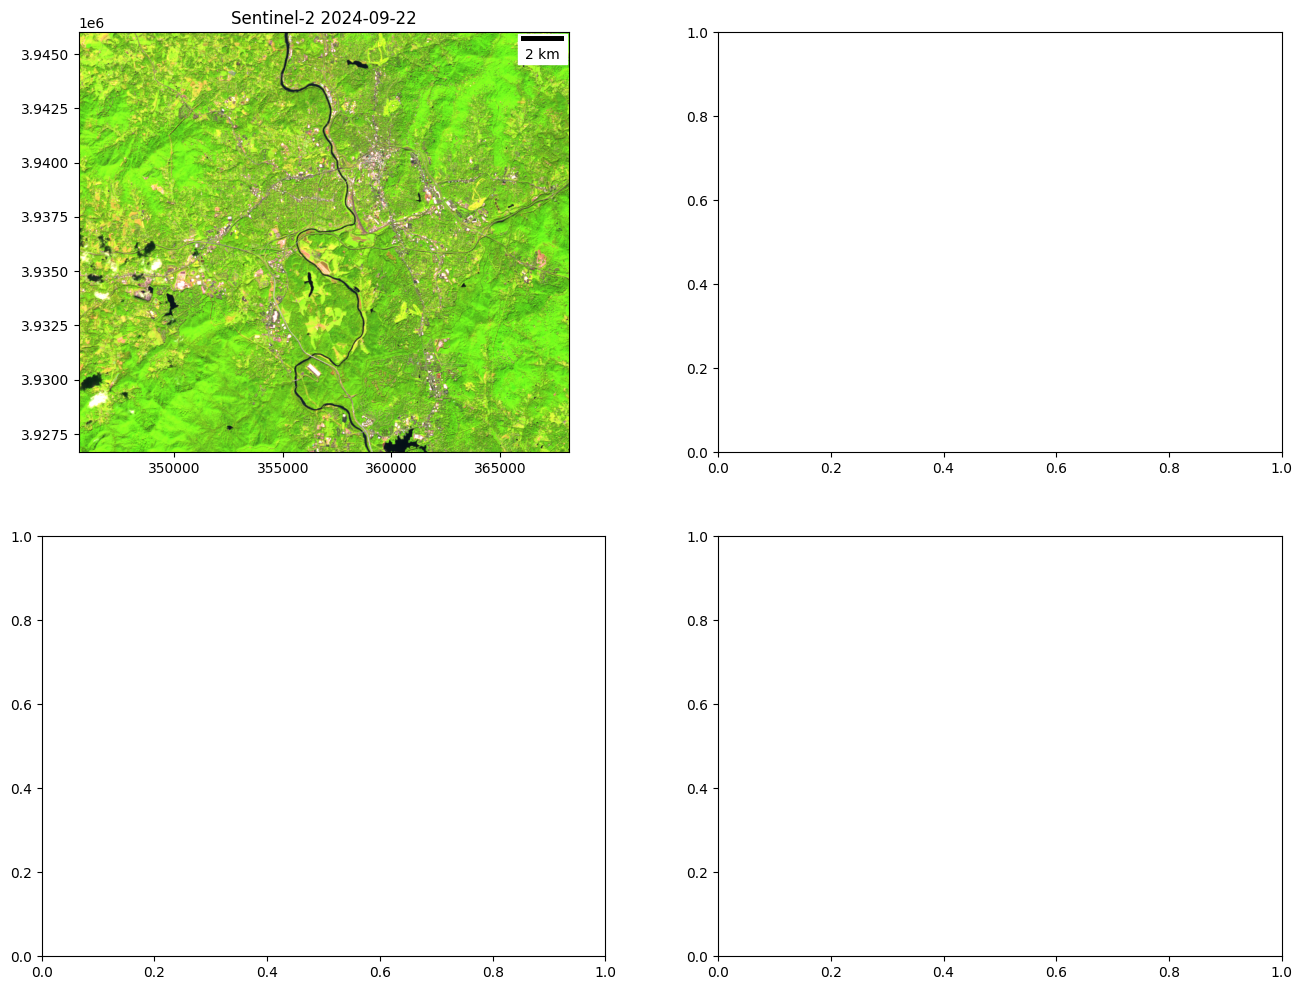

In [127]:
fig, ax = plt.subplots(2,2,figsize=(16,12),squeeze=False)


plot_utils.plot_swirnirred_image(pre_flood_memory,ax = ax[0,0],transform = pre_flood.transform, add_scalebar = True )
ax[0,0].set_title(f"Sentinel-2 {date_pre}")

plot_utils.plot_swirnirred_image(post_flood_memory,ax = ax[0,1],transform = post_flood.transform, add_scalebar = True )
ax[0,1].set_title(f"Sentinel-2 {date_post}")


plot.plot_segmentation_mask(prediction_preflood_raster, COLORS_PRED, ax=ax[1,0],
                            interpretation_array=["invalids", "land", "water", "cloud", "flood_trace"])


ax[1,0].set_title(f"{date_pre} floodmap")

plot.plot_segmentation_mask(prediction_postflood_raster, COLORS_PRED, ax=ax[1,1],
                            interpretation_array=["invalids", "land", "water", "cloud", "flood_trace"])

ax[1,1].set_title(f"{date_post} floodmap")

## Step 8: Vectorize predictions into prepost flood products

In [ ]:
prediction_preflood_raster.shape

(5700, 8800)

In [ ]:
preflood_shape = vectorize_outputv1(prediction_preflood_raster.values,
                                    prediction_preflood_raster.crs,
                                    prediction_preflood_raster.transform)
postflood_shape = vectorize_outputv1(prediction_postflood_raster.values,
                                     prediction_postflood_raster.crs,
                                     prediction_postflood_raster.transform)
postflood_shape.shape

(2893, 3)

Text(0.5, 1.0, '2023-06-08 floodmap')

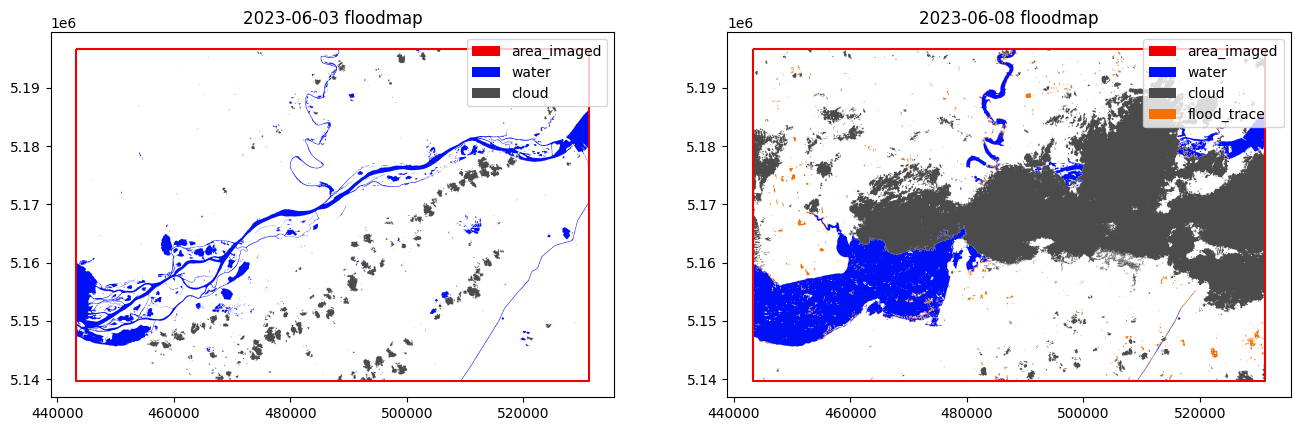

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 12))
plot_utils.plot_floodmap(preflood_shape, ax=ax[0])
ax[0].set_title(f"{date_pre} floodmap")
plot_utils.plot_floodmap(postflood_shape, ax=ax[1])
ax[1].set_title(f"{date_post} floodmap")

/home/gonzalo/mambaforge/envs/ml4floods2/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/home/gonzalo/mambaforge/envs/ml4floods2/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/home/gonzalo/mambaforge/envs/ml4floods2/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result =

<Axes: >

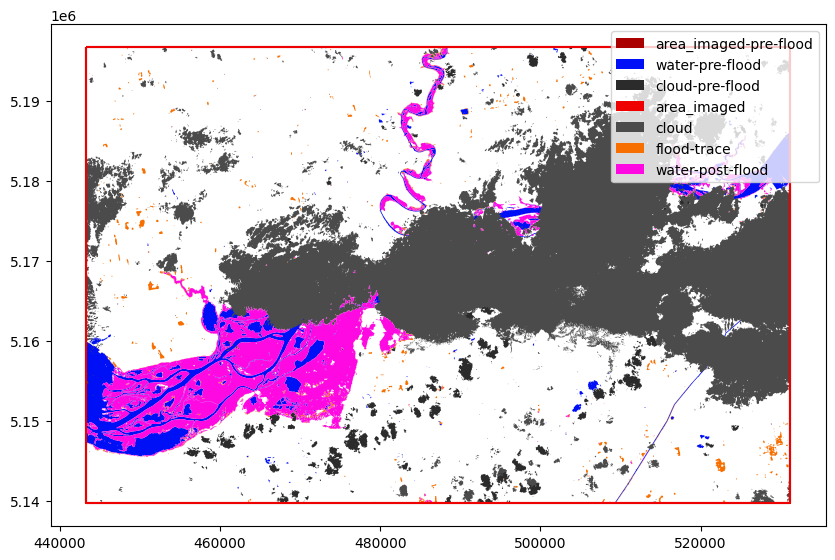

In [ ]:
prepost_shape = postprocess.compute_pre_post_flood_water(postflood_shape, preflood_shape)
plot_utils.plot_floodmap(prepost_shape)

## Step 9: Download Landsat 8/9

There is a cloud free Landsat 9 image from the 2023-06-09. In the following cells we downloaded the image from Google Earth Engine, we run inference on it and show how to aggregate several post-flood maps over time of images acquired by different sensors.

In [92]:
%%time

bands_l89 = ["B2", "B3", "B4", "B5", "B6", "B7"]
postfloodsl9 = []
for l89_image_info in flood_images_gee[flood_images_gee.solarday == date_pre].itertuples():
    asset_id = f"{l89_image_info.collection_name}/{l89_image_info.gee_id}"
    geom = l89_image_info.geometry.intersection(aoi)
    postfloodsl9.append(ee_image.export_image_getpixels(asset_id, geom, proj=l89_image_info.proj,
                                                        bands_gee=bands_l89))

CPU times: user 1.16 s, sys: 379 ms, total: 1.54 s
Wall time: 5.74 s


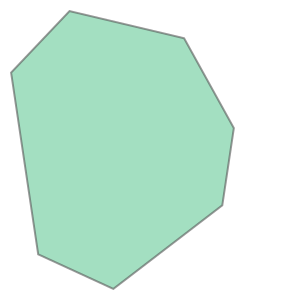

In [93]:
dst_crs = postfloodsl9[0].crs
aoi_dst_crs = window_utils.polygon_to_crs(aoi, crs_polygon="EPSG:4326", dst_crs=dst_crs)
aoi_dst_crs

In [94]:
postfloodl9 = mosaic.spatial_mosaic(postfloodsl9, polygon=aoi_dst_crs, dst_crs=dst_crs,
    dst_nodata=-9999)
postfloodl9.values[postfloodl9.values == postfloodl9.fill_value_default] = 0
postfloodl9.fill_value_default = 0

post_flood_l9_data = postfloodl9.values * 10000
postfloodl9

 
         Transform: | 30.00, 0.00, 318825.00|
| 0.00,-30.00, 3109575.00|
| 0.00, 0.00, 1.00|
         Shape: (6, 1679, 1347)
         Resolution: (30.0, 30.0)
         Bounds: (318825.0, 3059205.0, 359235.0, 3109575.0)
         CRS: EPSG:32617
         fill_value_default: 0
        

In [95]:
save_cog(postfloodl9, date_pre + ".tif", descriptions=bands_l89)

## Step 10: Run inference on Landsat image

In [96]:
postflood_pred = f"{date_pre}_pred.tif"

prediction_postflood, prediction_postflood_cont  = predict(post_flood_l9_data, channels = [0, 1, 2, 3, 4, 5])
prediction_postflood_raster = GeoTensor(prediction_postflood.numpy(), transform=postfloodl9.transform,
                                        fill_value_default=0, crs=postfloodl9.crs)

save_cog(prediction_postflood_raster, postflood_pred, descriptions=["pred"],
         tags={"0":"invalid", "1": "land", "2":"water", "3":"cloud", "4":"flood_trace"})


## Step 11: Plot Landsat images and floodmaps

In [97]:
COLORS_PRED = np.array([[0, 0, 0], # 0: invalid
                       [139, 64, 0], # 1: land
                       [0, 0, 240], # 2: water
                       [220, 220, 220], # 3: cloud
                       [60, 85, 92]], # 5: flood_trace
                    dtype=np.float32) / 255

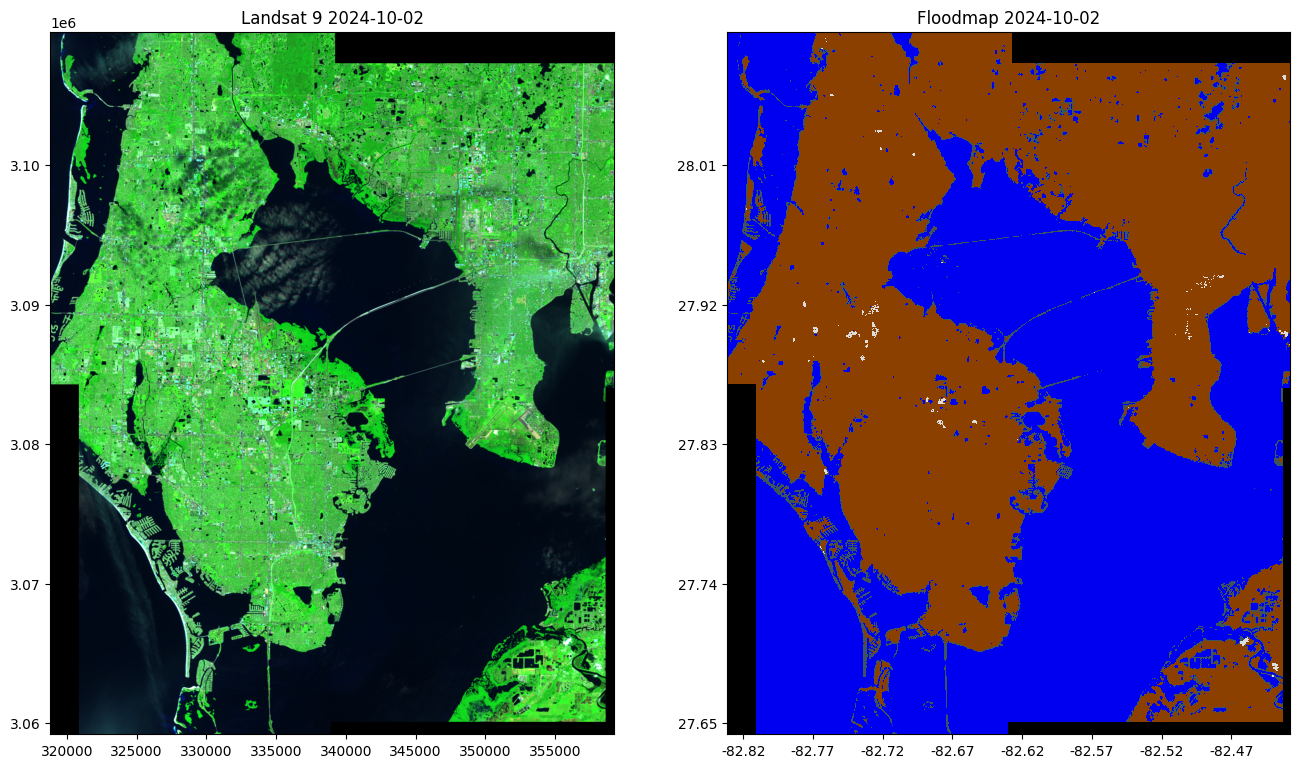

In [98]:
fig, ax = plt.subplots(1,2,figsize=(16,12))

show(np.clip(post_flood_l9_data[[5, 3, 2],:,:] / 3500, 0, 1),
     ax = ax[0],transform = postfloodl9.transform)


ax[0].set_title(f"Landsat 9 {date_pre}")


plot.plot_segmentation_mask(prediction_postflood_raster, COLORS_PRED, ax=ax[1],
                            interpretation_array=["invalids", "land", "water", "cloud", "flood_trace"], legend = False)
ax[1].set_title(f"Floodmap {date_pre}")

plt.show()

In [99]:
post_flood_shape_l9 = vectorize_outputv1(prediction_postflood_raster.values,
                                    prediction_postflood_raster.crs,
                                    prediction_postflood_raster.transform)

## Step 12: Join the floodmaps of Sentinel-2 and Landsat

Here we join the floodmaps of the two satellites using the `max` mode.

In [100]:
warnings.filterwarnings('ignore')

area_imaged = post_flood_shape_l9.loc[post_flood_shape_l9['class'] =='area_imaged']

# Remove flood traces for the max extent join
post_flood_shape_l9 = post_flood_shape_l9.loc[post_flood_shape_l9['class'] !='flood_trace']
post_flood_shape = post_flood_shape_l9.loc[post_flood_shape_l9['class'] !='flood_trace']

postflood_mosaic = postprocess.mosaic_floodmaps([post_flood_shape, post_flood_shape_l9], area_imaged.geometry.values[0], mode = 'max',
                                                classes_water=['water','flood_trace'])

Text(0.5, 1.0, 'Mosaic floodmap')

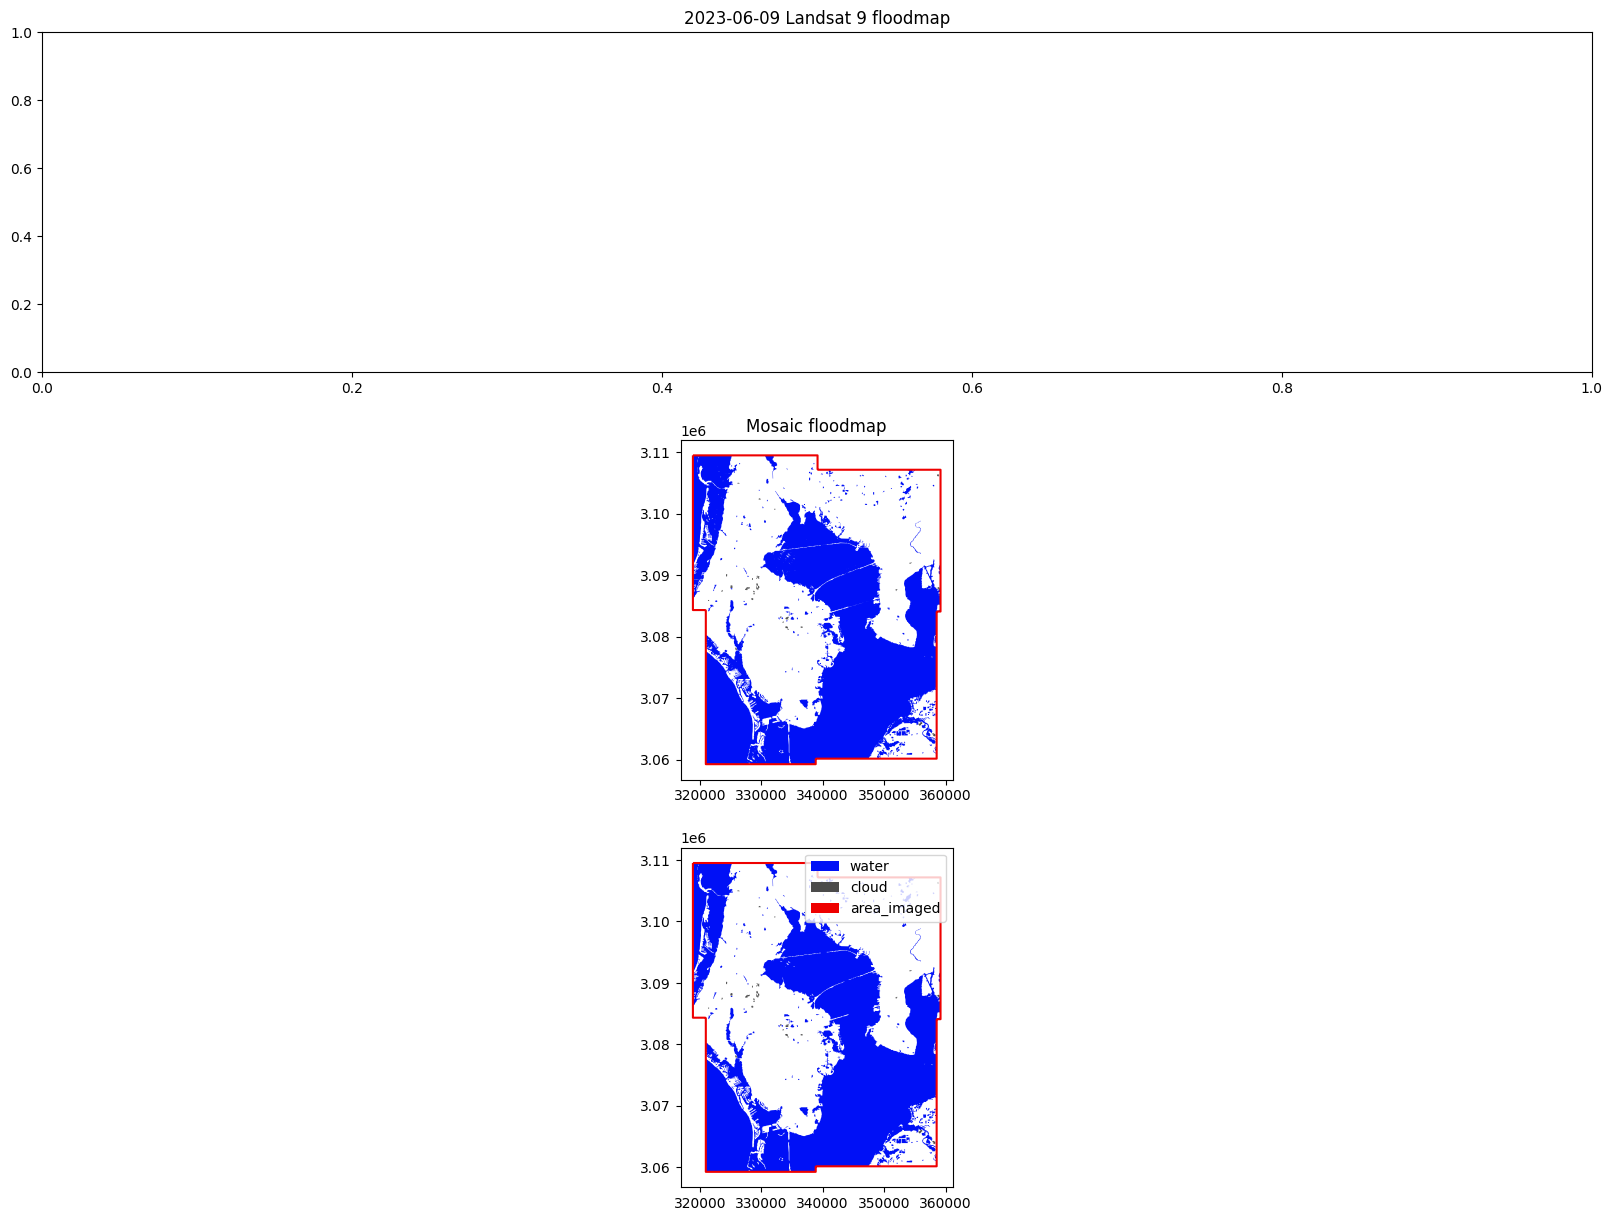

In [103]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
# plot_utils.plot_floodmap(post_flood_shape, ax=ax[0], legend = False)
# ax[0].set_title(f"{date_post} Sentinel-2 floodmap")
plot_utils.plot_floodmap(post_flood_shape_l9, ax=ax[1], legend = False)
ax[1].set_title(f"2023-06-09 Landsat 9 floodmap")
plot_utils.plot_floodmap(postflood_mosaic,ax = ax[2], legend = True)
ax[2].set_title(f"Mosaic floodmap")

In [102]:
prepost_shape_final = postprocess.compute_pre_post_flood_water(postflood_mosaic, preflood_shape)
prepost_shape_final = prepost_shape_final.loc[prepost_shape_final['class'].isin(['water-pre-flood','water-post-flood','area_imaged'])]
plot_utils.plot_floodmap(prepost_shape_final)

NameError: name 'preflood_shape' is not defined

## Licence
The ML4Floods package is published under a [GNU Lesser GPL v3 licence](https://www.gnu.org/licenses/lgpl-3.0.en.html)

The *WorldFloods* database and all pre-trained models are released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt). For using the models in comercial pipelines written consent by the authors must be provided.

The Ml4Floods notebooks and docs are released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt).

 If you find this work useful please cite:
```
@article{portales-julia_global_2023,
	title = {Global flood extent segmentation in optical satellite images},
	volume = {13},
	issn = {2045-2322},
	doi = {10.1038/s41598-023-47595-7},
	number = {1},
	urldate = {2023-11-30},
	journal = {Scientific Reports},
	author = {Portalés-Julià, Enrique and Mateo-García, Gonzalo and Purcell, Cormac and Gómez-Chova, Luis},
	month = nov,
	year = {2023},
	pages = {20316},
}
```

## Acknowledgments

This research has been supported by the DEEPCLOUD project (PID2019-109026RB-I00) funded by the Spanish Ministry of Science and Innovation (MCIN/AEI/10.13039/501100011033) and the European Union (NextGenerationEU).

<img width="300" title="DEEPCLOUD project (PID2019-109026RB-I00, University of Valencia) funded by MCIN/AEI/10.13039/501100011033." alt="DEEPCLOUD project (PID2019-109026RB-I00, University of Valencia) funded by MCIN/AEI/10.13039/501100011033." src="https://www.uv.es/chovago/logos/logoMICIN.jpg">